In [1]:
import argparse
import math
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time
import random
import torch.nn.functional as F

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image

from config import Config
from models import *
from generate_data import generate_data
import numpy as np
from scipy import spatial
parser = argparse.ArgumentParser(description='FQ-ViT')

parser.add_argument('--model',
                    choices=[
                        'deit_tiny', 'deit_small', 'deit_base', 'vit_base',
                        'vit_large', 'swin_tiny', 'swin_small', 'swin_base'
                    ],
                    default='deit_tiny',
                    help='model')
parser.add_argument('--data', metavar='DIR',
                    default='/home/jieungkim/quantctr/imagenet',
                    help='path to dataset')
parser.add_argument('--quant', default=True, action='store_true')
parser.add_argument('--ptf', default=False)
parser.add_argument('--lis', default=False)
parser.add_argument('--quant-method',
                    default='minmax',
                    choices=['minmax', 'ema', 'omse', 'percentile'])
parser.add_argument('--mixed', default=False, action='store_true')
# TODO: 100 --> 32
parser.add_argument('--calib-batchsize',
                    default=5,
                    type=int,
                    help='batchsize of calibration set')
parser.add_argument("--mode", default=0,
                        type=int, 
                        help="mode of calibration data, 0: PSAQ-ViT, 1: Gaussian noise, 2: Real data")
# TODO: 10 --> 1
parser.add_argument('--calib-iter', default=10, type=int)
# TODO: 100 --> 200
parser.add_argument('--val-batchsize',
                    default=5,
                    type=int,
                    help='batchsize of validation set')
parser.add_argument('--num-workers',
                    default=16,
                    type=int,
                    help='number of data loading workers (default: 16)')
parser.add_argument('--device', default='cuda', type=str, help='device')
parser.add_argument('--print-freq',
                    default=100,
                    type=int,
                    help='print frequency')
parser.add_argument('--seed', default=0, type=int, help='seed')


def str2model(name):
    d = {
        'deit_tiny': deit_tiny_patch16_224,
        'deit_small': deit_small_patch16_224,
        'deit_base': deit_base_patch16_224,
        'vit_base': vit_base_patch16_224,
        'vit_large': vit_large_patch16_224,
        'swin_tiny': swin_tiny_patch4_window7_224,
        'swin_small': swin_small_patch4_window7_224,
        'swin_base': swin_base_patch4_window7_224,
    }
    print('Model: %s' % d[name].__name__)
    return d[name]


def seed(seed=0):
    import os
    import random
    import sys

    import numpy as np
    import torch
    sys.setrecursionlimit(100000)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)

/home/jieungkim/.conda/envs/ptq4vit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def accuracy(output, target, topk=(1, )):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def build_transform(input_size=224,
                    interpolation='bicubic',
                    mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225),
                    crop_pct=0.875):

    def _pil_interp(method):
        if method == 'bicubic':
            return Image.BICUBIC
        elif method == 'lanczos':
            return Image.LANCZOS
        elif method == 'hamming':
            return Image.HAMMING
        else:
            return Image.BILINEAR

    resize_im = input_size > 32
    t = []
    if resize_im:
        size = int(math.floor(input_size / crop_pct))
        ip = _pil_interp(interpolation)
        t.append(
            transforms.Resize(
                size,
                interpolation=ip),  # to maintain same ratio w.r.t. 224 images
        )
        t.append(transforms.CenterCrop(input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(mean, std))
    return transforms.Compose(t)


In [3]:
def validate(args, val_loader, model, criterion, device, bit_config=None):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    val_start_time = end = time.time()
    for i, (data, target) in enumerate(val_loader):
        data = data.to(device)
        target = target.to(device)
        if i == 0:
            plot_flag = False
        else:
            plot_flag = False
        with torch.no_grad():
            output, FLOPs, distance = model(data, bit_config, plot_flag)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data.item(), data.size(0))
        top1.update(prec1.data.item(), data.size(0))
        top5.update(prec5.data.item(), data.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                      i,
                      len(val_loader),
                      batch_time=batch_time,
                      loss=losses,
                      top1=top1,
                      top5=top5,
                  ))
    val_end_time = time.time()
    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f} Time {time:.3f}'.
          format(top1=top1, top5=top5, time=val_end_time - val_start_time))

    return losses.avg, top1.avg, top5.avg

In [4]:
def model_make(model_name, ptf, lis, quant_method, device):
    device = torch.device(device)
    cfg = Config(ptf, lis, quant_method)
    model = str2model(model_name)(pretrained=True, cfg=cfg)
    model = model.to(device)
    return model
    
def calibrate_model(mode = 0, args = None, model = None, train_loader = None, device = None):
    if mode == 2:
        print("Generating data...")
        calibrate_data = generate_data(args)
        print("Calibrating with generated data...")
        model.model_open_calibrate()
        with torch.no_grad():
            model.model_open_last_calibrate()
            output = model(calibrate_data)
        return model
    # Case 1: Gaussian noise
    elif args.mode == 1:
        calibrate_data = torch.randn((args.calib_batchsize, 3, 224, 224)).to(device)
        print("Calibrating with Gaussian noise...")
        model.model_open_calibrate()
        with torch.no_grad():
            model.model_open_last_calibrate()
            output = model(calibrate_data)
        return model
    # Case 2: Real data (Standard)
    elif args.mode == 0:
        # Get calibration set.
        image_list = []
        # output_list = []
        for i, (data, target) in enumerate(train_loader):
            if i == args.calib_iter:
                break
            data = data.to(device)
            # target = target.to(device)
            image_list.append(data)
            # output_list.append(target)

        print("Calibrating with real data...")
        model.model_open_calibrate()
        with torch.no_grad():
            # TODO:
            # for i, image in enumerate(image_list):
            #     if i == len(image_list) - 1:
            #         # This is used for OMSE method to
            #         # calculate minimum quantization error
            #         model.model_open_last_calibrate()
            #     output, FLOPs, global_distance = model(image, plot=False)
            # model.model_quant(flag='off')
            model.model_open_last_calibrate()
            output, FLOPs, global_distance = model(image_list[0], plot=False)

    model.model_close_calibrate()
    model.model_quant()
    return model

In [5]:
args = parser.parse_args(args=[])
seed(args.seed)

device = torch.device(args.device)
cfg = Config(args.ptf, args.lis, args.quant_method)
# model = str2model(args.model)(pretrained=True, cfg=cfg)
# model = model.to(device)



# Note: Different models have different strategies of data preprocessing.
model_type = args.model.split('_')[0]
if model_type == 'deit':
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    crop_pct = 0.875
elif model_type == 'vit':
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)
    crop_pct = 0.9
elif model_type == 'swin':
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    crop_pct = 0.9
else:
    raise NotImplementedError
train_transform = build_transform(mean=mean, std=std, crop_pct=crop_pct)
val_transform = build_transform(mean=mean, std=std, crop_pct=crop_pct)

# Data
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

val_dataset = datasets.ImageFolder(valdir, val_transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=args.val_batchsize,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True,
)
# switch to evaluate mode
# model.eval()

# define loss function (criterion)
criterion = nn.CrossEntropyLoss().to(device)

train_dataset = datasets.ImageFolder(traindir, train_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=True,
)

In [6]:
def myloss(yhat, y):
	return -((yhat[:,0]-y[:,0])**2 + 0.1*((yhat[:,1:]-y[:,1:])**2).mean(1)).mean()

class AttackPGD(nn.Module):
    def __init__(self, basic_net, epsilon, step_size, num_steps, bit_config):
        super(AttackPGD, self).__init__()
        self.basic_net = basic_net
        self.step_size = step_size
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.bit_config = bit_config

    def forward(self, inputs, targets):
        self.basic_net.zero_grad()
        x = inputs.clone().detach()
        x = x + torch.zeros_like(x).uniform_(-self.epsilon, self.epsilon)
        for i in range(self.num_steps):
            x = x.clone().detach().requires_grad_(True)
            # with torch.enable_grad():
            outputs, Flops, distance = self.basic_net(x, self.bit_config, False)
            loss = F.cross_entropy(outputs, targets, reduction='sum')
            # loss = myloss(outputs, targets)
            loss.backward()
            # grad = torch.autograd.grad(loss, [x], create_graph=False)[0]
            grad = x.grad.clone()
            x = x + self.step_size*torch.sign(grad)
            x = torch.min(torch.max(x, inputs - self.epsilon), inputs + self.epsilon)
            x = torch.clamp(x, inputs.min().item(), inputs.max().item())
            # x = torch.clamp(x, 0, 1)
            
            with torch.no_grad():
                self.basic_net.eval()
                adv_output, Flops, distance= self.basic_net(x, self.bit_config, False)
            
        return adv_output, x

In [7]:
def get_seed_inputs(n, rand=False, input_shape = (3, 224, 224)):
    if rand:
        batch_input_size = (n, input_shape[0], input_shape[1], input_shape[2])
        images = np.random.normal(size = batch_input_size).astype(np.float32)
    else:
        model_type = args.model.split('_')[0]
        if model_type == 'deit':
            mean = (0.485, 0.456, 0.406)
            std = (0.229, 0.224, 0.225)
            crop_pct = 0.875
        elif model_type == 'vit':
            mean = (0.5, 0.5, 0.5)
            std = (0.5, 0.5, 0.5)
            crop_pct = 0.9
        elif model_type == 'swin':
            mean = (0.485, 0.456, 0.406)
            std = (0.229, 0.224, 0.225)
            crop_pct = 0.9
        else:
            raise NotImplementedError

        train_transform = build_transform(mean=mean, std=std, crop_pct=crop_pct)

        # Data
        traindir = os.path.join(args.data, 'train')

        train_dataset = datasets.ImageFolder(traindir, train_transform)
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=n,
            shuffle=True,
            num_workers=args.num_workers,
            pin_memory=True,
            drop_last=True,
        )
        
        images, labels = next(iter(train_loader))
    return images.cuda(), labels.cuda()
        
def get_dataset(n, input_shape = (3, 224, 224)):
    
    
    model_type = args.model.split('_')[0]
    if model_type == 'deit':
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        crop_pct = 0.875
    elif model_type == 'vit':
        mean = (0.5, 0.5, 0.5)
        std = (0.5, 0.5, 0.5)
        crop_pct = 0.9
    elif model_type == 'swin':
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        crop_pct = 0.9
    else:
        raise NotImplementedError

    train_transform = build_transform(mean=mean, std=std, crop_pct=crop_pct)

    # Data
    traindir = os.path.join(args.data, 'train')

    train_dataset = datasets.ImageFolder(traindir, train_transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=n,
        shuffle=True,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    
    
    return train_loader
        

def gen_adv_inputs(model, inputs, labels, bit_config, attack_net):
    model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    # bit_config = [8]*50
    with torch.no_grad():
        clean_output, FLOPs, distance = model(inputs, bit_config, plot=False)
    # output_shape = clean_output.shape
    # batch_size = output_shape[0]
    # num_classes = output_shape[1]
    
    """
    다양성 최대화:
    ModelDiff 논문의 4.2절에서는 생성된 입력의 다양성(diversity)을 강조합니다.
    target_outputs = output_mean - clean_output를 사용함으로써, 각 입력이 평균 출력과 다르게 되도록 유도하고 있습니다.
    이는 생성된 입력들이 서로 다른 특성을 가지도록 하는 데 도움이 됩니다.
    """
    output_mean = clean_output.mean(axis = 0)
    target_outputs = output_mean - clean_output
    """
    결정 경계 탐색:
    y = target_outputs * 1000에서 큰 스케일 팩터(1000)를 사용하는 것은,
    모델의 결정 경계를 더 잘 탐색하기 위한 것으로 보입니다.
    이는 논문의 Figure 3에서 설명하는 "decision boundary" 개념과 연관됩니다.
    """
    y = target_outputs * 1000 
    
    adv_outputs, adv_inputs = attack_net(inputs, labels)
    # adv_outputs, adv_inputs = attack_net(inputs, y)
    torch.cuda.empty_cache()
    return adv_inputs.detach()

def metrics_output_diversity(model, bit_config, inputs, use_torch=False):
    # 논문의 4.2절에서 설명한 출력 다양성 메트릭 계산
    outputs = model(inputs, bit_config, False)[0].detach().to('cpu').numpy()
#         output_dists = []
#         for i in range(0, len(outputs) - 1):
#             for j in range(i + 1, len(outputs)):
#                 output_dist = spatial.distance.euclidean(outputs[i], outputs[j])
#                 output_dists.append(output_dist)
#         diversity = sum(output_dists) / len(output_dists)
    # cdist 함수는 두 집합 모든 쌍 사이의 거리를 유클리드 거리를 이용해서 계산함.
    #outputs_dists는 모든 출력 쌍 사이의 거리를 담은 행렬.
    output_dists = spatial.distance.cdist(list(outputs), list(outputs), metric='euclidean')
    #계산된 모든 거리의 평균을 구함.
    diversity = np.mean(output_dists)
    return diversity

def gen_profiling_inputs_in_blackbox(model1, model1_bit_config, model2, model2_bit_config, seed_inputs, use_torch=False, epsilon=0.2):
    #논문의 4.2절에서 설명한 테스트 입력 생성 알고리즘 구현
    input_shape = seed_inputs[0].shape
    n_inputs = seed_inputs.shape[0]
    max_iterations = 1000 #최대 반복 횟수 설정
    # max_steps = 10 
    
    
    ndims = np.prod(input_shape) #입력의 총 차원 수 계산
#         mutate_positions = torch.randperm(ndims)

        # Move seed_inputs to GPU if not already
    if not seed_inputs.is_cuda:
        seed_inputs = seed_inputs.cuda()
        
    # 초기 모델의 출력 계산
    with torch.no_grad():
        initial_outputs1 = model1(seed_inputs, bit_config = model1_bit_config, plot=False)[0].detach().to('cpu').numpy()
        initial_outputs2 = model2(seed_inputs, bit_config = model2_bit_config, plot=False)[0].detach().to('cpu').numpy()
    
    def evaluate_inputs(inputs):
        #논문의 Equantion 1에서 설명한 score 함수 구현
        if isinstance(inputs, np.ndarray):
            inputs = torch.from_numpy(inputs).cuda()
        elif inputs.device.type != 'cuda':
            inputs = inputs.cuda()
        with torch.no_grad():
            outputs1 = model1(inputs, bit_config = model1_bit_config, plot=False)[0].detach().to('cpu').numpy()
            outputs2 = model2(inputs, bit_config = model2_bit_config, plot=False)[0].detach().to('cpu').numpy()
        
        metrics1 = metrics_output_diversity(model1, model1_bit_config, inputs) #diversity 계산
        metrics2 = metrics_output_diversity(model2, model2_bit_config, inputs) # diversity 계산


        # divergence 계산 (초기 출력과의 거리)
        output_dist1 = np.mean(spatial.distance.cdist(
            list(outputs1),
            list(initial_outputs1),
            metric='euclidean').diagonal())
        output_dist2 = np.mean(spatial.distance.cdist(
            list(outputs2),
            list(initial_outputs2),
            metric='euclidean').diagonal())
        print(f'  output distance: {output_dist1},{output_dist2}')
        print(f'  metrics: {metrics1},{metrics2}')
        # if mutated_metrics <= metrics:
        #     break
        
        #score 계산 : divergence와 diversity의 곱
        return output_dist1 * output_dist2 * metrics1 * metrics2
    
    inputs = seed_inputs
    score = evaluate_inputs(inputs)
    print(f'score={score}')
    
    for i in range(max_iterations):
        #Alogrithm 1: Search-based input generation 
        # comparator._compute_distance(inputs)
        print(f'mutation {i}-th iteration')
        # mutation_idx = random.randint(0, len(inputs))
        # mutation = np.random.random_sample(size=input_shape).astype(np.float32)
        
        #무작위 위치 선택하여 mutation 생성
        mutation_pos = np.random.randint(0, ndims)
        mutation = np.zeros(ndims).astype(np.float32)
        mutation[mutation_pos] = epsilon
        mutation = np.reshape(mutation, input_shape) #이 코드는 1차원 mutation 벡터를 원래 입력 데이터의 shape으로 재구성합니다.
        
        
        
        mutation_batch = torch.zeros_like(inputs)
        mutation_idx = np.random.randint(0, n_inputs)
        mutation_batch[mutation_idx] = torch.from_numpy(mutation).cuda()
        
        # print(f'{inputs.shape} {mutation_perturbation.shape}')
        # for j in range(max_steps):
            # mutated_inputs = np.clip(inputs + mutation, 0, 1)
            # print(f'{list(inputs)[0].shape}')
        mutate_right_inputs = inputs + mutation_batch
        mutate_right_score = evaluate_inputs(mutate_right_inputs)
        mutate_left_inputs = inputs - mutation_batch
        mutate_left_score = evaluate_inputs(mutate_left_inputs)
        
        if mutate_right_score <= score and mutate_left_score <= score:
            continue
        if mutate_right_score > mutate_left_score:
            print(f'mutate right: {score}->{mutate_right_score}')
            inputs = mutate_right_inputs
            score = mutate_right_score
        else:
            print(f'mutate left: {score}->{mutate_left_score}')
            inputs = mutate_left_inputs
            score = mutate_left_score
    return inputs


def gen_profiling_inputs_in_whitebox(model1, model1_bit_config, model2, model2_bit_config, seed_inputs, seed_labels, use_torch=False, epsilon=0.2, whitebox_attack_net=None):
    #논문의 4.2절에서 설명한 테스트 입력 생성 알고리즘 구현
    input_shape = seed_inputs[0].shape
    n_inputs = seed_inputs.shape[0]
    max_iterations = 20 #최대 반복 횟수 설정
    # max_steps = 10 
    
    
    ndims = np.prod(input_shape) #입력의 총 차원 수 계산
#         mutate_positions = torch.randperm(ndims)

        # Move seed_inputs to GPU if not already
    if not seed_inputs.is_cuda:
        seed_inputs = seed_inputs.cuda()
        
    # 초기 모델의 출력 계산
    with torch.no_grad():
        initial_outputs1 = model1(seed_inputs, bit_config = model1_bit_config, plot=False)[0].detach().to('cpu').numpy()
        initial_outputs2 = model2(seed_inputs, bit_config = model2_bit_config, plot=False)[0].detach().to('cpu').numpy()
    
    def evaluate_inputs(inputs):
        #논문의 Equantion 1에서 설명한 score 함수 구현
        if isinstance(inputs, np.ndarray):
            inputs = torch.from_numpy(inputs).cuda()     
        elif inputs.device.type != 'cuda':
            inputs = inputs.cuda()
        with torch.no_grad():
            outputs1 = model1(inputs, bit_config = model1_bit_config, plot=False)[0].detach().to('cpu').numpy()
            outputs2 = model2(inputs, bit_config = model2_bit_config, plot=False)[0].detach().to('cpu').numpy()
        
        metrics1 = metrics_output_diversity(model1, model1_bit_config, inputs) #diversity 계산
        metrics2 = metrics_output_diversity(model2, model2_bit_config, inputs) # diversity 계산


        # divergence 계산 (초기 출력과의 거리)
        output_dist1 = np.mean(spatial.distance.cdist(
            list(outputs1),
            list(initial_outputs1),
            metric='euclidean').diagonal())
        output_dist2 = np.mean(spatial.distance.cdist(
            list(outputs2),
            list(initial_outputs2),
            metric='euclidean').diagonal())
        print(f'  output distance: {output_dist1},{output_dist2}')
        print(f'  metrics: {metrics1},{metrics2}')
        # if mutated_metrics <= metrics:
        #     break
        
        #score 계산 : divergence와 diversity의 곱
        return output_dist1 * output_dist2 * metrics1 * metrics2
    
    inputs = seed_inputs
    max_inputs = None
    labels = seed_labels
    score = evaluate_inputs(inputs)
    print(f'score={score}')
    
    for i in range(max_iterations):
        #Alogrithm 1: Search-based input generation 
        # comparator._compute_distance(inputs)
        print(f'mutation {i}-th iteration')
        # mutation_idx = random.randint(0, len(inputs))
        # mutation = np.random.random_sample(size=input_shape).astype(np.float32)
        
        #무작위 위치 선택하여 mutation 생성
        current_adv_inputs = gen_adv_inputs(model1, inputs, labels, model1_bit_config, attack_net=whitebox_attack_net)
        
        current_score = evaluate_inputs(current_adv_inputs)
        
        
        if current_score > score:
            print(f'current score update: {score}->{current_score}')
            max_inputs = current_adv_inputs
            score = current_score
            
    
    return max_inputs




In [8]:
int8_model = model_make(args.model, args.ptf, args.lis, args.quant_method, args.device)
int4_model = model_make(args.model, args.ptf, args.lis, args.quant_method, args.device)
not_quantized_model = model_make(args.model, args.ptf, args.lis, args.quant_method, args.device)

eight_bit_config = [8]*50
not_quantized_attack_net = AttackPGD(not_quantized_model, epsilon=0.06, step_size=0.01, num_steps=50, bit_config=None)
four_bit_config = [4]*50
seed_images, seed_labels = get_seed_inputs(50, rand=False)
adv_inputs = gen_adv_inputs(not_quantized_model, seed_images, seed_labels, bit_config=None, attack_net=not_quantized_attack_net)
# mutation_inputs = gen_profiling_inputs_in_blackbox(not_quantized_model, None,  int4_model, four_bit_config, seed_images, epsilon=0.02)



Model: deit_tiny_patch16_224
Model: deit_tiny_patch16_224
Model: deit_tiny_patch16_224


In [9]:
# mutation_adv_inputs = gen_profiling_inputs_in_whitebox(not_quantized_model, None,  int4_model, four_bit_config, seed_images, seed_labels, epsilon=0.02, whitebox_attack_net=not_quantized_attack_net)

In [10]:

# int8_model = calibrate_model(args.mode, args, int8_model, train_loader, device)
# int4_model = calibrate_model(args.mode, args, int4_model, train_loader, device)


int8_model.eval()
int4_model.eval()
not_quantized_model.eval()

print()

# cka 계산하기

In [11]:
def normalize_activations(act):
    # 입력 텐서를 2D로 재구성합니다. 첫 번째 차원은 유지하고 나머지는 평탄화합니다.
    act = act.view(act.size(0), -1)

    # 각 샘플(행)에 대해 L2 norm을 계산합니다.
    act_norm = torch.norm(act, p=2, dim=1, keepdim=True)

    # 0으로 나누는 것을 방지하기 위해 작은 값을 더합니다.
    act_norm = act_norm + 1e-8

    # 각 샘플을 해당 norm으로 나누어 정규화합니다.
    act = act / act_norm

    return act
#torch model의 layers의 수를 확인한다.
from efficient_CKA import *

In [12]:
def get_activations(images, model, normalize_act=False):
    model = not_quantized_model

    



    def get_module_path(module):
        return f"{module.__class__.__module__}.{module.__class__.__name__}"

    activations = []
    layer_info = []
    from models.vit_fquant import Attention, Mlp
    def hook_return(index):
        def hook(module, input, output):
            if isinstance(module, Attention):
                activations.append(module.qkv_output)
                layer_info.append({
                'relative_index': len(activations) - 1,
                'absolute_index': index,
                'name': module.__class__.__name__,
                'layer_type': type(module),
                'path': get_module_path(module)

                })
            elif isinstance(module, Mlp):
                activations.append(module.fc1_output)
                layer_info.append({
                'relative_index': len(activations) - 1,
                'absolute_index': index,
                'name': module.__class__.__name__,
                'layer_type': type(module),
                'path': get_module_path(module)

                })
            else:    
                activations.append(output)
                layer_info.append({
                    'relative_index': len(activations) - 1,
                    'absolute_index': index,
                    'name': module.__class__.__name__,
                    'layer_type': type(module),
                    'path': get_module_path(module)

                })
            

        return hook

    hooks = []


    for index, layer in enumerate(model.modules()):
        if type(layer) in [QConv2d, QLinear, Attention, Mlp]:
            hooks.append(layer.register_forward_hook(hook_return(index)))

    # 모델을 통해 이미지를 전달합니다.
    images = images.cuda()
    _ = model(images)

    # 등록된 후크를 제거합니다.
    for h in hooks:
        h.remove()





    # layer_info와 activations를 절대 인덱스를 기준으로 정렬
    sorted_indices = sorted(range(len(layer_info)), key=lambda k: layer_info[k]['absolute_index'])
    layer_info = [layer_info[i] for i in sorted_indices]
    activations = [activations[i] for i in sorted_indices]

    # 상대 인덱스 재할당
    for i, info in enumerate(layer_info):
        info['relative_index'] = i


    if normalize_act:
        activations = [normalize_activations(act) for act in activations]
    return activations
    # 정렬된 레이어 정보 출력
    # for info in layer_info:
    #     print(f"Layer {info['relative_index']}(absolute: {info['absolute_index']}): {info['name']} (Type: {info['layer_type']}, Path: {info['path']})")

    # print(f"\nTotal number of activations: {len(activations)}")

In [13]:
import pickle
def compute_cka_internal(model, use_batch = True,
                         use_train_mode = False,
                         normalize_act = False,
                         cka_batch = 50,
                         cka_batch_iter = 10,
                         cka_iter = 10):
    model.eval()

    sample_cka_dataset = get_dataset(cka_batch)

    sample_cka_dataset = next(iter(sample_cka_dataset))

    sample_images, _ = sample_cka_dataset
    # n_layers = len(list(not_quantized_model.children()))
    # n_layers = len([layer for layer in model.modules() if isinstance(layer, (nn.Conv2d, nn.Linear))])

    sample_activations = get_activations(sample_images, model)
    n_layers = len(sample_activations)

    cka = MinibatchCKA(n_layers)







    # 사용 예시:
    # model = YourModel()  # PyTorch 모델을 정의하세요
    # images = torch.randn(10, 3, 224, 224)  # 예시 입력 이미지
    # activations = get_activations(images, model, normalize_act=True)


    
    

    if use_batch:
        for index in range(cka_iter):
            #cka_batch만큼, shuffle해서, 데이터셋을 가져온다.
            cka_dataset = get_dataset(cka_batch)
            current_iter = 0
            for images, _ in cka_dataset:
                model_get_activation = get_activations(images, model, normalize_act) #각 모델의 레이어별 활성화를 가져온다.

                cka.update_state(model_get_activation) #레이어 마다의 activation을 다 가져옴. 예를 들어 24 * 50 * feature^2. 
                
                if current_iter > cka_batch_iter:
                    break
                current_iter += 1
            print("현재 반복:", index)
    else:
        cka_dataset = get_dataset(cka_batch)
        all_images = []
        for images, _ in cka_dataset:
            all_images.append(images)
        cka.update_state(get_activations(all_images, model, normalize_act))
    heatmap = cka.result().cpu().numpy()
    with open('cka_result.pkl', 'wb') as f:
        #pickle로 heatmap을 저장한다.
        pickle.dump(heatmap, f)

In [14]:
sample_cka_dataset = get_dataset(50)

sample_cka_dataset = next(iter(sample_cka_dataset))

sample_images, _ = sample_cka_dataset
# n_layers = len(list(not_quantized_model.children()))
# n_layers = len([layer for layer in model.modules() if isinstance(layer, (nn.Conv2d, nn.Linear))])

sample_activations = get_activations(sample_images, not_quantized_model)
n_layers = len(sample_activations)

print(n_layers)

50


In [16]:
compute_cka_internal(not_quantized_model, use_batch = True, normalize_act = False, cka_batch = 10, cka_iter = 20)


현재 반복: 0
현재 반복: 1
현재 반복: 2
현재 반복: 3
현재 반복: 4
현재 반복: 5
현재 반복: 6
현재 반복: 7
현재 반복: 8
현재 반복: 9
현재 반복: 10
현재 반복: 11
현재 반복: 12
현재 반복: 13
현재 반복: 14
현재 반복: 15
현재 반복: 16
현재 반복: 17
현재 반복: 18
현재 반복: 19


## CKA Plot

layers [4, 21, 29, 46, 51, 61, 69, 86, 91, 101, 109, 126, 131, 141, 149, 166, 171, 181, 189, 206, 211, 221, 229, 246, 251, 261, 269, 286, 291, 301, 309, 326, 331, 341, 349, 366, 371, 381, 389, 406, 411, 421, 429, 446, 451, 461, 469, 486, 491, 502]
x | y : 1 1


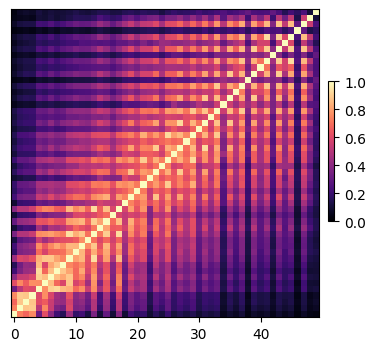

In [17]:
# 필요한 라이브러리 임포트
import torch
import argparse
import os
import pickle
import numpy as np
from plot import *


base_dir = '/home/jieungkim/quantctr/diff-ViT'



# GPU 설정


# CKA 결과 파일 경로 설정
cka_dir = os.path.join(base_dir, 'cka_result.pkl')
best_model = not_quantized_model
# 저장된 모델 불러오기
# best_model = torch.load(os.path.join(base_dir, 'model.pth'))

# 'add' 연산이 포함된 레이어의 인덱스 찾기
layers = []
best_model.eval()
# print("model.modules.length", len([module for module in best_model.modules()])) // 506
with torch.no_grad():
    for i, module in enumerate(best_model.modules()):
        # print(module.__class__.__name__.lower())
        # if isinstance(module, torch.nn.Module) and 'mlp' in module.__class__.__name__.lower():
        if type(module) in [QConv2d, QLinear]:
            layers.append(i)
print("layers", layers)

# CKA 결과 불러오기
with open(cka_dir, 'rb') as f:
    cka = pickle.load(f)

# 특정 레이어에 대한 CKA 결과 추출
# cka1 = cka[layers][:, layers]
# print(cka.shape, cka1.shape)

# 추출된 CKA 결과 저장
out_dir = os.path.join(base_dir, 'cka_within_unquantized_model.pkl')
# with open(out_dir, 'wb') as f:
#     pickle.dump(cka1, f)

# 전체 레이어에 대한 CKA 결과 플롯 생성
plot_dir = os.path.join(base_dir, 'layer')
plot_ckalist_resume([cka], plot_dir)

# 특정 블록에 대한 CKA 결과 플롯 생성
# plot_dir = os.path.join(base_dir, 'block')
# plot_ckalist_resume([cka1], plot_dir)

In [17]:
# batch_time = AverageMeter()
# losses = AverageMeter()
# top1 = AverageMeter()
# top5 = AverageMeter()
# # not_quantized_attack_net = AttackPGD(not_quantized_model, epsilon=0.02, step_size=0.01, num_steps=50, bit_config=None)

#     # switch to evaluate mode
    

# val_start_time = end = time.time()
# for i, (inputs, labels) in enumerate(val_loader):
#     int8_model.eval()
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     eight_bit_config = [8]*50
#     four_bit_config = [4] * 50
#     with torch.no_grad():
#         clean_output, FLOPs, distance = not_quantized_model(inputs, plot=False)
#     # output_shape = clean_output.shape
#     # batch_size = output_shape[0]
#     # num_classes = output_shape[1]
    
    
#     output_mean = clean_output.mean(axis = 0)
#     target_outputs = output_mean - clean_output
    
#     y = target_outputs * 1000 
    
#     # adv_outputs, adv_inputs = attack_net(inputs, y)
#     adv_outputs, adv_inputs = attack_net(inputs, labels)

#     adv_inputs = adv_inputs.to(device)
#     labels = labels.to(device)
#     if i == 0:
#         plot_flag = False
#     else:
#         plot_flag = False
#     with torch.no_grad():
#         output, FLOPs, distance = int4_model(adv_inputs, four_bit_config, plot_flag)
#     loss = criterion(output, labels)

#     # measure accuracy and record loss
#     prec1, prec5 = accuracy(output.data, labels, topk=(1, 5))
#     losses.update(loss.data.item(), adv_inputs.size(0))
#     top1.update(prec1.data.item(), adv_inputs.size(0))
#     top5.update(prec5.data.item(), adv_inputs.size(0))

#     # measure elapsed time
#     batch_time.update(time.time() - end)
#     end = time.time()

#     if i % 10 == 0:
#         print('Test: [{0}/{1}]\t'
#                 'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
#                 'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
#                 'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
#                 'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
#                     i,
#                     len(val_loader),
#                     batch_time=batch_time,
#                     loss=losses,
#                     top1=top1,
#                     top5=top5,
#                 ))
# val_end_time = time.time()
# print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f} Time {time:.3f}'.
#         format(top1=top1, top5=top5, time=val_end_time - val_start_time))


In [18]:
def hook_fn(name, model_outputs):
    def hook(module, input, output):
        model_outputs[name] = output
    return hook

int8_outputs = {}
int4_outputs = {}
not_quantized_outputs = {}
def add_hooks(model, model_outputs):
    # Input quantization
    model.qact_input.register_forward_hook(hook_fn("qact_input", model_outputs))
    
    # Patch Embedding
    model.patch_embed.register_forward_hook(hook_fn("patch_embed", model_outputs))
    model.patch_embed.qact.register_forward_hook(hook_fn("patch_embed_qact", model_outputs))
    
    # Position Embedding
    model.pos_drop.register_forward_hook(hook_fn("pos_drop", model_outputs))
    model.qact_embed.register_forward_hook(hook_fn("qact_embed", model_outputs))
    model.qact_pos.register_forward_hook(hook_fn("qact_pos", model_outputs))
    
    # Transformer Blocks
    for i, block in enumerate(model.blocks):
        block.norm1.register_forward_hook(hook_fn(f"block_{i}_norm1", model_outputs))
        block.attn.qkv.register_forward_hook(hook_fn(f"block_{i}_attn_qkv", model_outputs))
        block.attn.proj.register_forward_hook(hook_fn(f"block_{i}_attn_proj", model_outputs))
        block.attn.qact3.register_forward_hook(hook_fn(f"block_{i}_attn_qact3", model_outputs))
        block.qact2.register_forward_hook(hook_fn(f"block_{i}_qact2", model_outputs))
        block.norm2.register_forward_hook(hook_fn(f"block_{i}_norm2", model_outputs))
        block.mlp.fc1.register_forward_hook(hook_fn(f"block_{i}_mlp_fc1", model_outputs))
        block.mlp.fc2.register_forward_hook(hook_fn(f"block_{i}_mlp_fc2", model_outputs))
        block.mlp.qact2.register_forward_hook(hook_fn(f"block_{i}_mlp_qact2", model_outputs))
        block.qact4.register_forward_hook(hook_fn(f"block_{i}_qact4", model_outputs))
    
    # Final Norm Layer
    model.norm.register_forward_hook(hook_fn("final_norm", model_outputs))
    model.qact2.register_forward_hook(hook_fn("final_qact2", model_outputs))
    
    # Classifier Head
    model.head.register_forward_hook(hook_fn("head", model_outputs))
    model.act_out.register_forward_hook(hook_fn("act_out", model_outputs))
    
add_hooks(int8_model, int8_outputs)
add_hooks(int4_model, int4_outputs)
add_hooks(not_quantized_model, not_quantized_outputs)

In [19]:
def compute_ddv(model, normal_inputs, adv_inputs, outputs, bit_config = None):
    if bit_config is not None:
        model(normal_inputs, bit_config=bit_config, plot=False)    
    else:
        model(normal_inputs, plot=False)
    normal_outputs = {k: v.clone() for k, v in outputs.items()}
    
    
    # 적대적 입력에 대한 출력 저장
    if bit_config is not None:
        model(adv_inputs, bit_config=bit_config, plot=False)
    else:
        model(adv_inputs, plot=False)
    adv_outputs = {k: v.clone() for k, v in outputs.items()}
    
    # print(normal_outputs.keys())
    # print(adv_outputs.keys())

    model_ddv_dict = {}
    #dictionary int8_outputs을 모두 출력한다.
    for key in normal_outputs.keys():
    
        #각 레이어에 대해 normal_outputs와 adv_outputs을 묶은 batch size만큼의 output을 저장한다.
        specific_layers_output_pairs = zip(normal_outputs[key], adv_outputs[key])
    
        ddv = []
        # 각 레이어에서 각각의 이미지에 대해 normal output과 adv output의 cosine similarity를 계산한다.
        for i, (ya, yb) in enumerate(specific_layers_output_pairs):
            #ya와 yb의 cosiene similarity를 계산
            # dist = spatial.distance.cosine(ya, yb) -> 대체
            ya = ya.detach().cpu().numpy().flatten()
            yb = yb.detach().cpu().numpy().flatten()
            ya = ya / np.linalg.norm(ya)
            yb = yb / np.linalg.norm(yb)
            cos_similarity = np.dot(ya, yb)
            ddv.append(cos_similarity)
        ddv = np.array(ddv)
        norm = np.linalg.norm(ddv)
        if norm != 0:
            ddv = ddv/ norm
        model_ddv_dict[key] = ddv
        # print(key, "레이어에서", ddv.shape)
    return model_ddv_dict
    

In [20]:
int8_bit_config = [8]*50
int4_bit_config = [4]*50
int8_ddv = compute_ddv(int8_model, seed_images, adv_inputs, int8_outputs, int8_bit_config)
int4_ddv = compute_ddv(int4_model, seed_images, adv_inputs, int4_outputs, int4_bit_config)
not_quantized_ddv = compute_ddv(not_quantized_model, seed_images, adv_inputs, not_quantized_outputs)

    
def calculate_and_print_similarities(source_ddv, target_ddv):
    for key in source_ddv.keys():
    

        #각 레이어에 대해 normal_outputs와 adv_outputs을 묶은 batch size만큼의 output을 저장한다.
        if not (key in target_ddv.keys()):
            continue
        specific_layers_output_pairs = zip(source_ddv[key], target_ddv[key])


        # 각 레이어에서 각각의 이미지에 대해 normal output과 adv output의 cosine similarity를 계산한다.
        for i, (ya, yb) in enumerate(specific_layers_output_pairs):
            #ya와 yb의 cosiene similarity를 계산
            # dist = spatial.distance.cosine(ya, yb) -> 대체
            ya = ya / np.linalg.norm(ya)
            yb = yb / np.linalg.norm(yb)
            cos_similarity = np.dot(ya, yb) * 100
            
        
            # norm = np.linalg.norm(cos_similarity)
            # if norm != 0:
                # cos_similarity = cos_similarity/ norm
            
            # print(key, "레이어에서", cos_similarity)

# calculate_and_print_similarities(int8_ddv, int4_ddv)
calculate_and_print_similarities(int8_ddv, not_quantized_ddv)
calculate_and_print_similarities(int4_ddv, not_quantized_ddv)
# print(int8_ddv.keys())
# print(int4_outputs.keys())
        
    

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 7.66 GiB of which 5.69 MiB is free. Process 224057 has 1.30 GiB memory in use. Including non-PyTorch memory, this process has 6.32 GiB memory in use. Of the allocated memory 5.31 GiB is allocated by PyTorch, and 859.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
int8_bit_config = [8]*50
int4_bit_config = [4]*50
int8_ddv = compute_ddv(int8_model, seed_images, mutation_adv_inputs, int8_outputs, int8_bit_config)
int4_ddv = compute_ddv(int4_model, seed_images, mutation_adv_inputs, int4_outputs, int4_bit_config)
not_quantized_ddv = compute_ddv(not_quantized_model, seed_images, mutation_adv_inputs, not_quantized_outputs)

    
def calculate_and_print_similarities(source_ddv, target_ddv):
    for key in source_ddv.keys():
    

        #각 레이어에 대해 normal_outputs와 adv_outputs을 묶은 batch size만큼의 output을 저장한다.
        if not (key in target_ddv.keys()):
            continue
        specific_layers_output_pairs = zip(source_ddv[key], target_ddv[key])


        # 각 레이어에서 각각의 이미지에 대해 normal output과 adv output의 cosine similarity를 계산한다.
        for i, (ya, yb) in enumerate(specific_layers_output_pairs):
            #ya와 yb의 cosiene similarity를 계산
            # dist = spatial.distance.cosine(ya, yb) -> 대체
            ya = ya / np.linalg.norm(ya)
            yb = yb / np.linalg.norm(yb)
            cos_similarity = np.dot(ya, yb) * 100
            
        
            # norm = np.linalg.norm(cos_similarity)
            # if norm != 0:
                # cos_similarity = cos_similarity/ norm
            
            # print(key, "레이어에서", cos_similarity)

# calculate_and_print_similarities(int8_ddv, int4_ddv)
calculate_and_print_similarities(int8_ddv, not_quantized_ddv)
calculate_and_print_similarities(int4_ddv, not_quantized_ddv)
# print(int8_ddv.keys())
# print(int4_outputs.keys())
        
    

In [21]:
torch.cuda.empty_cache()

In [22]:
#int8div와 int4div의 value를 각각 조회해 array의 차이를 출력한다.
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)  # 두 벡터의 내적
    norm_vec1 = np.linalg.norm(vec1)  # 첫 번째 벡터의 크기 (norm)
    norm_vec2 = np.linalg.norm(vec2)  # 두 번째 벡터의 크기 (norm)
    
    return dot_product / (norm_vec1 * norm_vec2) 


for key in int8_ddv.keys():
    if  (key in not_quantized_ddv.keys()):
        int8_similarity = cosine_similarity(int8_ddv[key], not_quantized_ddv[key])
        int4_similarity = cosine_similarity(int4_ddv[key], not_quantized_ddv[key])
        int8_similarity = (int8_similarity + 1) /2 * 100
        int4_similarity = (int4_similarity + 1) /2 * 100
        print(f'{key}, "레이어에서", {int8_similarity:.2f}, {int4_similarity:.2f}')
        
        
        
        
        # 절대적 변화율 계산
        # print(np.abs(diff).mean() * 100)
        #difference를 통해 mse를 구한다.
        # mse = np.square(difference).mean()
        # print(mse)
        
# print("int4_ddv - not_quantized_ddv")
#         print(np.array(int4_ddv[key] - not_quantized_ddv[key]).mean()/2 * 100)


qact_input, "레이어에서", 100.00, 100.00
patch_embed_qact, "레이어에서", 100.00, 100.00
patch_embed, "레이어에서", 100.00, 100.00
qact_embed, "레이어에서", 100.00, 100.00
qact_pos, "레이어에서", 100.00, 100.00
pos_drop, "레이어에서", 100.00, 100.00
block_0_norm1, "레이어에서", 100.00, 100.00
block_0_attn_proj, "레이어에서", 100.00, 100.00
block_0_attn_qact3, "레이어에서", 100.00, 100.00
block_0_qact2, "레이어에서", 100.00, 100.00
block_0_norm2, "레이어에서", 100.00, 100.00
block_0_mlp_fc2, "레이어에서", 100.00, 100.00
block_0_mlp_qact2, "레이어에서", 100.00, 100.00
block_0_qact4, "레이어에서", 100.00, 100.00
block_1_norm1, "레이어에서", 100.00, 100.00
block_1_attn_proj, "레이어에서", 100.00, 100.00
block_1_attn_qact3, "레이어에서", 100.00, 100.00
block_1_qact2, "레이어에서", 100.00, 100.00
block_1_norm2, "레이어에서", 100.00, 100.00
block_1_mlp_fc2, "레이어에서", 99.99, 99.99
block_1_mlp_qact2, "레이어에서", 99.99, 99.99
block_1_qact4, "레이어에서", 100.00, 100.00
block_2_norm1, "레이어에서", 100.00, 99.99
block_2_attn_proj, "레이어에서", 99.99, 99.99
block_2_attn_qact3, "레이어에서", 99.99, 99.99
block_2_qa

In [18]:
# batch_time = AverageMeter()
# losses = AverageMeter()
# top1 = AverageMeter()
# top5 = AverageMeter()
# # not_quantized_attack_net = AttackPGD(not_quantized_model, epsilon=0.02, step_size=0.01, num_steps=50, bit_config=bit_config)

#     # switch to evaluate mode
    

# val_start_time = end = time.time()
# for i, (inputs, labels) in enumerate(val_loader):
#     int8_model.eval()
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     bit_config = [8]*50
#     with torch.no_grad():
#         clean_output, FLOPs, distance = int8_model(inputs, bit_config, plot=False)
#     # output_shape = clean_output.shape
#     # batch_size = output_shape[0]
#     # num_classes = output_shape[1]
    
    
#     output_mean = clean_output.mean(axis = 0)
#     target_outputs = output_mean - clean_output
    
#     y = target_outputs * 1000 
    
#     adv_outputs, adv_inputs = attack_net(inputs, y)
#     adv_inputs = adv_inputs.to(device)
#     labels = labels.to(device)
#     if i == 0:
#         plot_flag = False
#     else:
#         plot_flag = False
#     with torch.no_grad():
#         output, FLOPs, distance = int8_model(inputs, bit_config, plot_flag)
#     loss = criterion(output, labels)

#     # measure accuracy and record loss
#     prec1, prec5 = accuracy(output.data, labels, topk=(1, 5))
#     losses.update(loss.data.item(), adv_inputs.size(0))
#     top1.update(prec1.data.item(), adv_inputs.size(0))
#     top5.update(prec5.data.item(), adv_inputs.size(0))

#     # measure elapsed time
#     batch_time.update(time.time() - end)
#     end = time.time()

#     if i % 10 == 0:
#         print('Test: [{0}/{1}]\t'
#                 'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
#                 'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
#                 'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
#                 'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
#                     i,
#                     len(val_loader),
#                     batch_time=batch_time,
#                     loss=losses,
#                     top1=top1,
#                     top5=top5,
#                 ))
# val_end_time = time.time()
# print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f} Time {time:.3f}'.
#         format(top1=top1, top5=top5, time=val_end_time - val_start_time))


In [19]:
# batch_time = AverageMeter()
# losses = AverageMeter()
# top1 = AverageMeter()
# top5 = AverageMeter()
# # not_quantized_attack_net = AttackPGD(not_quantized_model, epsilon=0.02, step_size=0.01, num_steps=50, bit_config=bit_config)

#     # switch to evaluate mode
    

# val_start_time = end = time.time()
# for i, (inputs, labels) in enumerate(val_loader):
#     int8_model.eval()
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     bit_config = [4]*50
#     with torch.no_grad():
#         clean_output, FLOPs, distance = not_quantized_model(inputs, plot=False)
#     # output_shape = clean_output.shape
#     # batch_size = output_shape[0]
#     # num_classes = output_shape[1]
    
    
#     output_mean = clean_output.mean(axis = 0)
#     target_outputs = output_mean - clean_output
    
#     y = target_outputs * 1000 
    
#     adv_outputs, adv_inputs = attack_net(inputs, y)
#     adv_inputs = adv_inputs.to(device)
#     labels = labels.to(device)
#     if i == 0:
#         plot_flag = False
#     else:
#         plot_flag = False
#     with torch.no_grad():
#         output, FLOPs, distance = int4_model(adv_inputs, bit_config, plot_flag)
#     loss = criterion(output, labels)

#     # measure accuracy and record loss
#     prec1, prec5 = accuracy(output.data, labels, topk=(1, 5))
#     losses.update(loss.data.item(), adv_inputs.size(0))
#     top1.update(prec1.data.item(), adv_inputs.size(0))
#     top5.update(prec5.data.item(), adv_inputs.size(0))

#     # measure elapsed time
#     batch_time.update(time.time() - end)
#     end = time.time()

#     if i % 10 == 0:
#         print('Test: [{0}/{1}]\t'
#                 'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
#                 'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
#                 'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
#                 'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
#                     i,
#                     len(val_loader),
#                     batch_time=batch_time,
#                     loss=losses,
#                     top1=top1,
#                     top5=top5,
#                 ))
# val_end_time = time.time()
# print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f} Time {time:.3f}'.
#         format(top1=top1, top5=top5, time=val_end_time - val_start_time))
